In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys

sys.path.append("../../../../XRaySimulation")
from XRaySimulation import util, Crystal, RayTracing

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

In [5]:
theta = np.deg2rad(0.2)
gap = 1e3
distance = gap / np.sin(2 * theta)
print("The distance between the mirror is {:.2f} mm".format(distance/1e3))

The distance between the mirror is 143.24 mm


In [6]:
2 / np.tan(np.deg2rad(0.15) * 2)

381.9683727556649

In [7]:
6.7 * 2.5

16.75

In [5]:
100 * util.c / (np.cos(np.deg2rad(0.35)) - 1) / 1e6

-1.6067977880774125

Unit: fs, um, keV
axis: (x or horizontal, y or vertical, z or X-ray initial propagation direction)

In [6]:
class SplitDelay:
    """
    I realized that this is a fairly simple system
    Therefore, I might just create a true model of it.
    
    At this moment, I only add the optics and do not add motors.
    Adding motors is still a little bit challenging at this moment since
    I may want to change the motor model later. 
    """

    def __init__(self,
                 energy_kev=9.0,
                 grating_period=1.0,
                 refractive_idx=complex(1 - 0.90236E-05, +0.95681E-08),
                 mirror_sep=2.9e6,
                 g2_distance=6e6,
                 mirror_angle=np.deg2rad(0.2)  # This is the central angle
                 ):
        # Calculate the wavelength
        wavelength = np.pi * 2 / util.kev_to_wavevec_length(energy_kev)
        wavevec = util.kev_to_wavevec_length(energy_kev)

        # pi phase shift groove depth
        depth = wavelength / 2 / (1 - refractive_idx.real)
        print("To get the pi phase shift for dimaond, the corresponding groove depth is {:.2f} um".format(depth))

        # Calculate the diffraction order
        grating_k = np.pi * 2 / grating_period

        # Calculate the grating angle
        grating_angle = np.arctan(grating_k / wavevec)
        print("The grating diffraction angle for 1st order is {:.1f} mdeg".format(1000 * np.rad2deg(grating_angle)))

        # Calculate the spatial separation for 1m of propagation
        sep1m = grating_k / wavevec * 1e6
        print("The spatial separation of the +- 1st order at 1m distance is {:.1f} um".format(sep1m * 2))

        # Define the observation point
        self.obsevation = np.array([0., 0., g2_distance + 1e6])

        # Create the first grating for the two branches
        self.grating1p = Crystal.RectangleGrating(
            a=grating_period / 2.,
            b=grating_period / 2.,
            n=refractive_idx,
            height=depth,
            base_thickness=10.,
            direction=np.array([1., 0., 0.], dtype=np.float64),
            surface_point=np.zeros(3),
            normal=np.array([0., 0., 1.], dtype=np.float64),
            order=1.,
        )

        self.grating1m = Crystal.RectangleGrating(
            a=grating_period / 2.,
            b=grating_period / 2.,
            n=refractive_idx,
            height=depth,
            base_thickness=10.,
            direction=np.array([1., 0., 0.], dtype=np.float64),
            surface_point=np.zeros(3),
            normal=np.array([0., 0., 1.], dtype=np.float64),
            order=-1.,
        )

        # Create the second grating for branches 
        self.grating2p = Crystal.RectangleGrating(
            a=grating_period / 2.,
            b=grating_period / 2.,
            n=refractive_idx,
            height=depth,
            base_thickness=10.,
            direction=np.array([1., 0., 0.], dtype=np.float64),
            surface_point=np.array([0, 0, g2_distance]),
            normal=np.array([0., 0., 1.], dtype=np.float64),
            order=1.,
        )

        self.grating2m = Crystal.RectangleGrating(
            a=grating_period / 2.,
            b=grating_period / 2.,
            n=refractive_idx,
            height=depth,
            base_thickness=10.,
            direction=np.array([1., 0., 0.], dtype=np.float64),
            surface_point=np.array([0, 0, g2_distance]),
            normal=np.array([0., 0., 1.], dtype=np.float64),
            order=-1.,
        )

        # Calculate the mirror distance 
        sep_mirror_z = mirror_sep
        sep_mirror_x = mirror_sep / 1e6 * sep1m  # the x offset for the arrangement

        # Create the 4 mirrors
        self.m1 = Crystal.TotalReflectionMirror(surface_point=np.zeros(3), normal=np.array([-1., 0., 0.]))
        rot_mat = util.get_rotmat_around_axis(angleRadian=-grating_angle - mirror_angle, axis=np.array([0., 1., 0.]))
        self.m1.rotate_wrt_point(rot_mat=rot_mat, ref_point=np.copy(self.m1.surface_point))
        self.m1.shift(displacement=np.array([sep_mirror_x, 0, sep_mirror_z]))

        self.m2 = Crystal.TotalReflectionMirror(surface_point=np.zeros(3), normal=np.array([1., 0., 0.]))
        rot_mat = util.get_rotmat_around_axis(angleRadian=grating_angle + mirror_angle, axis=np.array([0., 1., 0.]))
        self.m2.rotate_wrt_point(rot_mat=rot_mat, ref_point=np.copy(self.m2.surface_point))
        self.m2.shift(displacement=np.array([-sep_mirror_x, 0, sep_mirror_z]))

        self.m3 = Crystal.TotalReflectionMirror(surface_point=np.zeros(3), normal=np.array([-1., 0., 0.]))
        rot_mat = util.get_rotmat_around_axis(angleRadian=grating_angle + mirror_angle, axis=np.array([0., 1., 0.]))
        self.m3.rotate_wrt_point(rot_mat=rot_mat, ref_point=np.copy(self.m3.surface_point))
        self.m3.shift(displacement=np.array([sep_mirror_x, 0, g2_distance - sep_mirror_z]))

        self.m4 = Crystal.TotalReflectionMirror(surface_point=np.zeros(3), normal=np.array([1., 0., 0.]))
        rot_mat = util.get_rotmat_around_axis(angleRadian=-grating_angle - mirror_angle, axis=np.array([0., 1., 0.]))
        self.m4.rotate_wrt_point(rot_mat=rot_mat, ref_point=np.copy(self.m4.surface_point))
        self.m4.shift(displacement=np.array([-sep_mirror_x, 0, g2_distance - sep_mirror_z]))

    def get_trajectory(self, kin_, initial_point, verbose=False):
        device_list1 = [self.grating1p, self.m1, self.m4, self.grating2m]
        # Calculate the trajectory
        (trajectory1,
         kout1_,
         path1_) = RayTracing.get_lightpath(device_list=device_list1,
                                            kin=np.copy(kin_),
                                            initial_point=np.copy(initial_point),
                                            final_plane_point=self.obsevation,
                                            final_plane_normal=np.array([0., 0., 1.])
                                            )

        # Calculate the trajectory for the other side
        device_list2 = [self.grating1m, self.m2, self.m3, self.grating2p]
        (trajectory2,
         kout2_,
         path2_) = RayTracing.get_lightpath(device_list=device_list2,
                                            kin=np.copy(kin_),
                                            initial_point=np.copy(initial_point),
                                            final_plane_point=self.obsevation,
                                            final_plane_normal=np.array([0., 0., 1.])
                                            )

        return trajectory1, trajectory2, kout1_, kout2_, path1_, path2_

To get the pi phase shift for dimaond, the corresponding groove depth is 7.63 um
The grating diffraction angle for 1st order is 7.9 mdeg
The spatial separation of the +- 1st order at 1m distance is 275.5 um


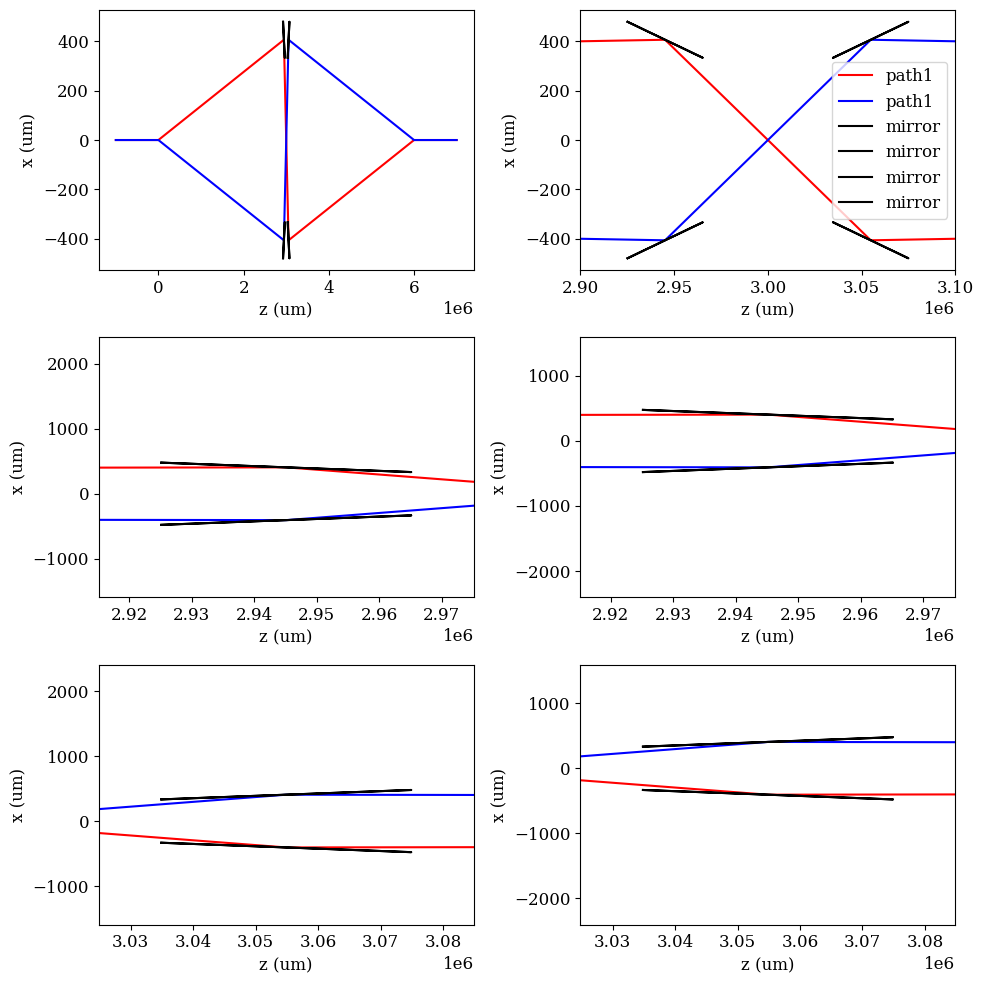

In [7]:
# Create my system
energy_kev = 9.0

mySD = SplitDelay(energy_kev=energy_kev,
                  grating_period=1.0,
                  refractive_idx=complex(1 - 0.90236E-05, 0.95681E-08),
                  mirror_sep=2.939e6 + 61.336 * 1e2,
                  g2_distance=6e6,
                  mirror_angle=np.deg2rad(0.2))

# Calculate the situation for the standard situation
k_len = util.kev_to_wavevec_length(energy_kev)
kin = np.array([0., 0., k_len])
source_position = np.array([0., 0., -1e6])

### Calculate the trajectory
(traj_1, traj_2,
 kout1, kout2,
 path1, path2) = mySD.get_trajectory(kin_=kin,
                                     initial_point=source_position, )

# Calculate the current spatial separation
separation = traj_2[-1] - traj_1[-1]

# Plot the trajectory
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)

# Show the total trajectory
ax[0, 0].plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
ax[0, 0].plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')

for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
    ax[0, 0].plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')

# Show the total trajectory
ax[0, 1].plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
ax[0, 1].plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')
for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
    ax[0, 1].plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')
middle = (mySD.grating1m.surface_point + mySD.grating2m.surface_point) / 2.
ax[0, 1].set_xlim([middle[2] - 100e3, middle[2] + 100e3])
ax[0, 1].legend()

# Show the trajectory around the mirrors
for target in [[1, 0, mySD.m1], [1, 1, mySD.m2], [2, 0, mySD.m3], [2, 1, mySD.m4]]:
    ax_here = ax[target[0], target[1]]
    ax_here.plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
    ax_here.plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')
    for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
        ax_here.plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')
    ax_here.set_xlim([target[2].surface_point[2] - 30e3, target[2].surface_point[2] + 30e3])
    ax_here.set_ylim([target[2].surface_point[0] - 2e3, target[2].surface_point[0] + 2e3])

for idx_x in range(3):
    for idx_y in range(2):
        ax[idx_x, idx_y].set_xlabel("z (um)")
        ax[idx_x, idx_y].set_ylabel("x (um)")
        
plt.tight_layout()
plt.show()

To get the pi phase shift for dimaond, the corresponding groove depth is 7.63 um
The grating diffraction angle for 1st order is 7.9 mdeg
The spatial separation of the +- 1st order at 1m distance is 275.5 um


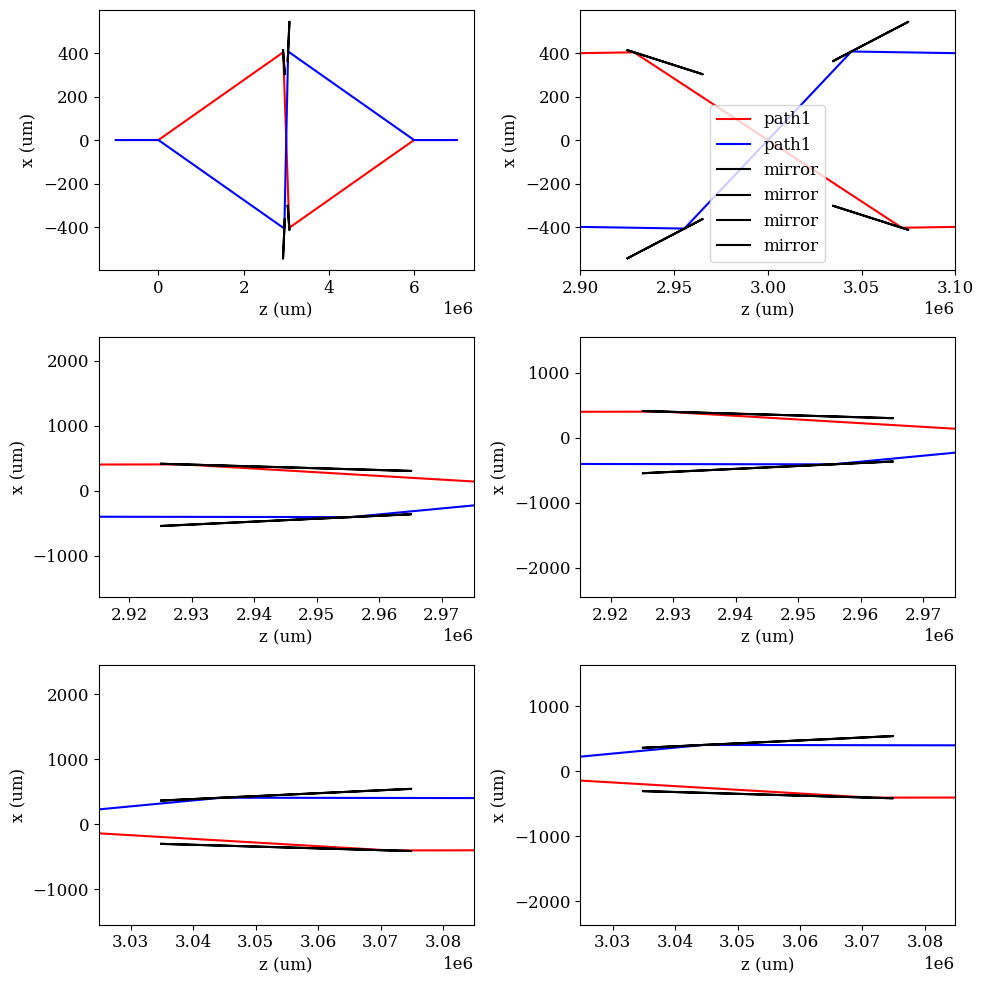

In [8]:
# Create my system
energy_kev = 9.0

mySD = SplitDelay(energy_kev=energy_kev,
                  grating_period=1.0,
                  refractive_idx=complex(1 - 0.90236E-05, 0.95681E-08),
                  mirror_sep=2.939e6 + 61.336 * 1e2,
                  g2_distance=6e6,
                  mirror_angle=np.deg2rad(0.2))

# Calculate the situation for the standard situation
k_len = util.kev_to_wavevec_length(energy_kev)
kin = np.array([0., 0., k_len])
source_position = np.array([0., 0., -1e6])
middle = (mySD.grating1m.surface_point + mySD.grating2m.surface_point) / 2.

# Rotate around the center by 0.1 deg
rot_mat = util.get_rotmat_around_axis(angleRadian=np.deg2rad(0.05), axis=np.array([0., 1., 0.]))
for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
    optics.rotate_wrt_point(rot_mat=rot_mat, ref_point=np.copy(middle))
    
### Calculate the trajectory
(traj_1, traj_2,
 kout1, kout2,
 path1, path2) = mySD.get_trajectory(kin_=kin,
                                     initial_point=source_position, )

# Calculate the current spatial separation
separation = traj_2[-1] - traj_1[-1]

# Plot the trajectory
fig, ax = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)

# Show the total trajectory
ax[0, 0].plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
ax[0, 0].plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')

for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
    ax[0, 0].plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')

# Show the total trajectory
ax[0, 1].plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
ax[0, 1].plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')
for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
    ax[0, 1].plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')
ax[0, 1].set_xlim([middle[2] - 100e3, middle[2] + 100e3])
ax[0, 1].legend()

# Show the trajectory around the mirrors
for target in [[1, 0, mySD.m1], [1, 1, mySD.m2], [2, 0, mySD.m3], [2, 1, mySD.m4]]:
    ax_here = ax[target[0], target[1]]
    ax_here.plot(traj_1[:, 2], traj_1[:, 0], c='r', label='path1')
    ax_here.plot(traj_2[:, 2], traj_2[:, 0], c='b', label='path1')
    for optics in [mySD.m1, mySD.m2, mySD.m3, mySD.m4]:
        ax_here.plot(optics.boundary[:, 2], optics.boundary[:, 0], c='k', label='mirror')
    ax_here.set_xlim([target[2].surface_point[2] - 30e3, target[2].surface_point[2] + 30e3])
    ax_here.set_ylim([target[2].surface_point[0] - 2e3, target[2].surface_point[0] + 2e3])

for idx_x in range(3):
    for idx_y in range(2):
        ax[idx_x, idx_y].set_xlabel("z (um)")
        ax[idx_x, idx_y].set_ylabel("x (um)")
        
plt.tight_layout()
plt.show()


In [10]:
10e-3 / (path1 - path2) * 0.05

-0.00034659117257043173